In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

from importlib import reload
from neuropacks import PVC11
from noise_correlations import (analysis,
                                plot,
                                utils)

%matplotlib inline

In [2]:
path1 = os.path.join(os.environ['HOME'], 'data/pvc11/data/spikes_gratings/data_monkey1_gratings.mat')
path2 = os.path.join(os.environ['HOME'], 'data/pvc11/data/spikes_gratings/data_monkey2_gratings.mat')
path3 = os.path.join(os.environ['HOME'], 'data/pvc11/data/spikes_gratings/data_monkey3_gratings.mat')

In [3]:
pvc1 = PVC11(path1)
pvc2 = PVC11(path2)
pvc3 = PVC11(path3)

In [4]:
var_to_mean_threshold = 10
responsive_threshold = 2.5 * 1.28
tuned_threshold = 0.50

# Monkey 1

In [5]:
X1 = pvc1.get_response_matrix(transform=None)
stimuli1 = pvc1.get_design_matrix(form='angle')

In [6]:
tuned_units = utils.get_tuned_units(
    X=X1, stimuli=stimuli1, aggregator=np.median,
    peak_response=responsive_threshold,
    modulation_frac=tuned_threshold,
    variance_to_mean=var_to_mean_threshold)
responsive_units = utils.get_responsive_units(
    X=X1, stimuli=stimuli1, aggregator=np.median,
    peak_response=responsive_threshold,
    variance_to_mean=var_to_mean_threshold)
responsive_not_tuned_units = responsive_units & ~tuned_units
non_responsive_units = ~responsive_units

## Tuning Curves

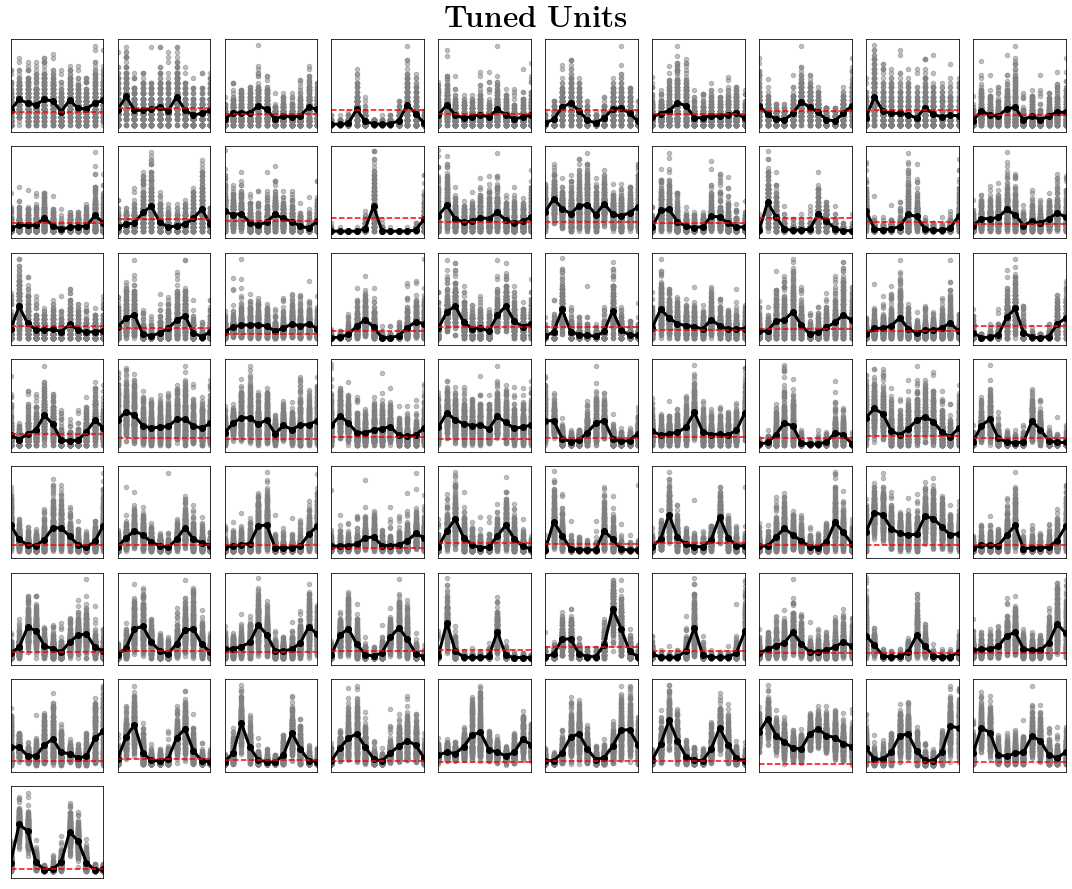

In [62]:
fig, axes = plot.plot_tuning_curves(
    X1[:, tuned_units], stimuli1,
    n_cols=10, include_points=True, use_title=False,
    sort='modulation'
)
for idx, ax in enumerate(axes.ravel()):
    if idx < tuned_units.sum():
        ax.axhline(responsive_threshold, color='r', linestyle='--')

fig.text(x=0.5, y=1.01, s=r'\textbf{Tuned Units}',
         va='center', ha='center', fontsize=30)
plt.tight_layout()
plt.savefig('pvc11_monkey1_tuned.png', bbox_inches='tight')
plt.show()

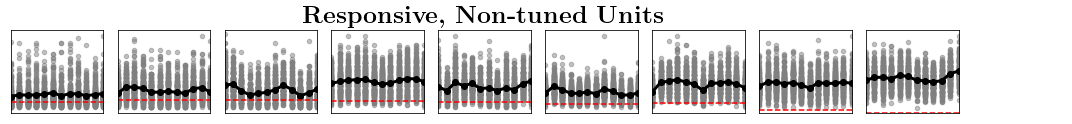

In [63]:
fig, axes = plot.plot_tuning_curves(
    X1[:, responsive_not_tuned_units], stimuli1, n_cols=10, include_points=True, use_title=False,
    sort='peak'
)
for idx, ax in enumerate(axes.ravel()):
    if idx < responsive_not_tuned_units.sum():
        ax.axhline(responsive_threshold, color='r', linestyle='--')

fig.text(x=0.45, y=1.02, s=r'\textbf{Responsive, Non-tuned Units}',
         va='center', ha='center', fontsize=25)
plt.tight_layout()
plt.savefig('pvc11_monkey1_responsive_non_tuned.png', bbox_inches='tight')
plt.show()

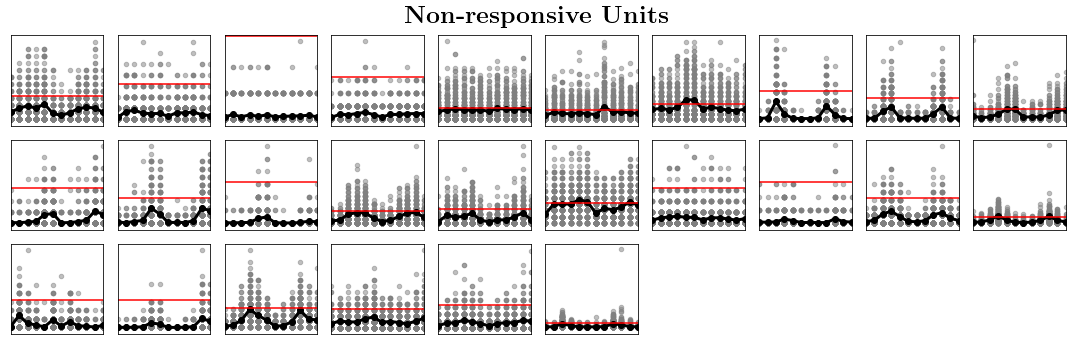

In [64]:
fig, axes = plot.plot_tuning_curves(
    X1[:, non_responsive_units], stimuli1,
    n_cols=10, include_points=True, use_title=False
)
for idx, ax in enumerate(axes.ravel()):
    if idx < non_responsive_units.sum():
        ax.axhline(responsive_threshold, color='r')

fig.text(x=0.5, y=1.02, s=r'\textbf{Non-responsive Units}',
         va='center', ha='center', fontsize=25)
plt.tight_layout()
plt.savefig('pvc11_monkey1_non_responsive.png', bbox_inches='tight')
plt.show()

## Noise correlations

In [65]:
all_corrs = analysis.all_correlations(X1, stimuli1)
tuned_corrs = analysis.all_correlations(X1, stimuli1, u1=tuned_units)
responsive_corrs = analysis.all_correlations(X1, stimuli1, u1=responsive_units)
responsive_non_tuned = analysis.all_correlations(X1, stimuli1, u1=responsive_not_tuned_units)
non_responsive_corrs = analysis.all_correlations(X1, stimuli1, u1=non_responsive_units)

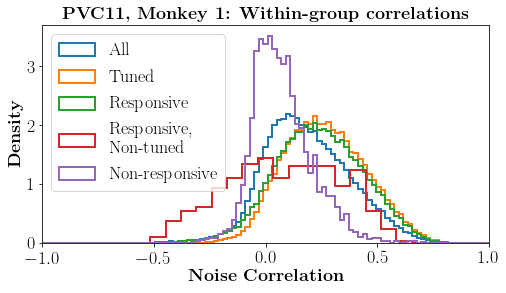

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

bins = np.linspace(-1, 1, 100)
ax.hist(all_corrs, bins=bins,
        density=True,
        histtype='step',
        linewidth=2,
        label='All')
ax.hist(tuned_corrs, bins=bins,
        density=True,
        histtype='step',
        linewidth=2,
        label='Tuned')
ax.hist(responsive_corrs, bins=bins,
        density=True,
        histtype='step',
        linewidth=2,
        label='Responsive')
ax.hist(responsive_non_tuned, bins=np.linspace(-1, 1, 30),
        density=True,
        histtype='step',
        linewidth=2,
        label='Responsive,\nNon-tuned')
ax.hist(non_responsive_corrs, bins=bins,
        density=True,
        histtype='step',
        linewidth=2,
        label='Non-responsive')

ax.set_xlim([-1, 1])
ax.set_xticks([-1, -0.5, 0, 0.5, 1])
ax.tick_params(labelsize=18)
ax.set_xlabel(r'\textbf{Noise Correlation}', fontsize=18)
ax.set_ylabel(r'\textbf{Density}', fontsize=18)
ax.set_title(r'\textbf{PVC11, Monkey 1: Within-group correlations}', fontsize=18)
plt.legend(loc=2, prop={'size': 18})
plt.savefig('pvc11_monkey1_within_group_noise_correlations.pdf', bbox_inches='tight')
plt.show()

In [69]:
tuned_by_non_tuned_corrs = analysis.all_correlations(X1, stimuli1,
                                                     u1=tuned_units,
                                                     u2=~tuned_units)
tuned_by_responsive_non_tuned_corrs = analysis.all_correlations(X1, stimuli1,
                                                                u1=tuned_units,
                                                                u2=responsive_not_tuned_units)
responsive_by_non_responsive_corrs = analysis.all_correlations(X1, stimuli1,
                                                               u1=responsive_units,
                                                               u2=~responsive_units)
tuned_by_non_responsive_corrs = analysis.all_correlations(X1, stimuli1,
                                                          u1=tuned_units,
                                                          u2=~responsive_units)

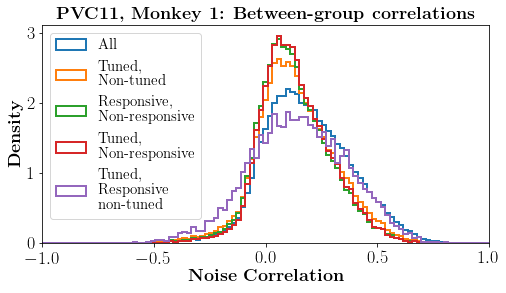

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

bins = np.linspace(-1, 1, 100)
ax.hist(all_corrs, bins=bins,
        density=True,
        histtype='step',
        linewidth=2,
        label='All')
ax.hist(tuned_by_non_tuned_corrs, bins=bins,
        density=True,
        histtype='step',
        linewidth=2,
        label='Tuned,\nNon-tuned')
ax.hist(responsive_by_non_responsive_corrs, bins=bins,
        density=True,
        histtype='step',
        linewidth=2,
        label='Responsive,\nNon-responsive')
ax.hist(tuned_by_non_responsive_corrs, bins=bins,
        density=True,
        histtype='step',
        linewidth=2,
        label='Tuned,\nNon-responsive')
ax.hist(tuned_by_responsive_non_tuned_corrs, bins=bins,
        density=True,
        histtype='step',
        linewidth=2,
        label='Tuned,\nResponsive\nnon-tuned')

ax.set_xlim([-1, 1])
ax.set_xticks([-1, -0.5, 0, 0.5, 1])
ax.tick_params(labelsize=18)
ax.set_xlabel(r'\textbf{Noise Correlation}', fontsize=18)
ax.set_ylabel(r'\textbf{Density}', fontsize=18)
ax.set_title(r'\textbf{PVC11, Monkey 1: Between-group correlations}', fontsize=18)
plt.legend(loc=2, prop={'size': 15})
plt.savefig('pvc11_monkey1_between_group_noise_correlations.pdf', bbox_inches='tight')
plt.show()

# Monkey 2

In [14]:
X2 = pvc2.get_response_matrix(transform=None)
stimuli2 = pvc2.get_design_matrix(form='angle')

In [ ]:
tuned_units = utils.get_tuned_units(
    X=X2, stimuli=stimuli2, aggregator=np.median,
    peak_response=responsive_threshold,
    modulation_frac=tuned_threshold,
    variance_to_mean=var_to_mean_threshold)
responsive_units = utils.get_responsive_units(
    X=X2, stimuli=stimuli2, aggregator=np.median,
    peak_response=responsive_threshold,
    variance_to_mean=var_to_mean_threshold)
responsive_not_tuned_units = responsive_units & ~tuned_units
non_responsive_units = ~responsive_units

In [23]:
%%time

rng = np.random.RandomState(2332)

_p_s_lfi, _p_s_sdkl, _p_r_lfi, _p_r_sdkl, _v_lfi, _v_sdkl = \
    analysis.compare_nulls_measures(
        X=X_tuned, stimuli=stimuli, n_dim=2, n_dimlets=800,
        rng=rng, n_repeats=100, circular_stim=True
    )

CPU times: user 2min 31s, sys: 2.7 s, total: 2min 34s
Wall time: 3min 11s


In [25]:
with np.load('pvc11_2_800_100.npz') as data:
    p_s_lfi =data['p_s_lfi'].ravel()
    p_s_sdl = data['p_s_sdkl'].ravel()
    p_r_lfi = data['p_r_lfi'].ravel()
    p_r_sdkl = data['p_r_sdkl'].ravel()
    v_lfi = data['v_lfi'].ravel()
    v_sdkl = data['v_sdkl'].ravel()

In [26]:
v_lfi.shape

(800,)

(<Figure size 360x360 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c3e9b7710>)

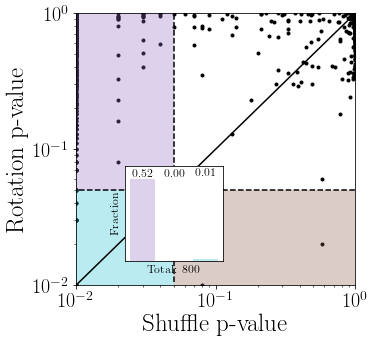

In [27]:
plot.plot_pvalue_comparison(p0s=p_s_lfi, p1s=p_r_lfi, labels=['Shuffle p-value', 'Rotation p-value'],
                            insetfontsize=12)

(<Figure size 360x360 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c390e76d0>)

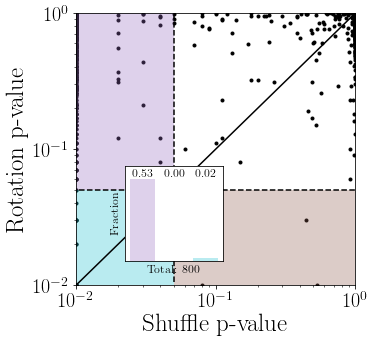

In [24]:
plot.plot_pvalue_comparison(p0s=_p_s_lfi, p1s=_p_r_lfi, labels=['Shuffle p-value', 'Rotation p-value'],
                            insetfontsize=12)

Text(0.5, 1.0, 'sD$_{KL}$')

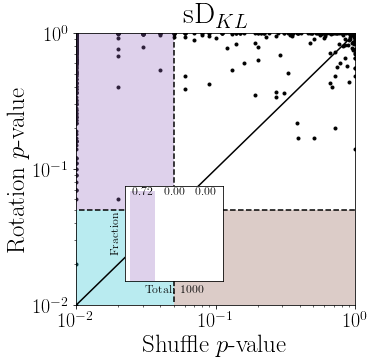

In [48]:
fig, ax = plot.plot_pvalue_comparison(
    p0s=p_s_sdkl, p1s=p_r_sdkl, labels=['Shuffle $p$-value', 'Rotation $p$-value'], insetfontsize=12
)
ax.set_title('sD$_{KL}$')